In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib.patches as ptch
from matplotlib.widgets import Slider
from matplotlib.widgets import Button
import astropy.constants as c
import astropy.units as u
import random
import numpy as np
import math
from deco import concurrent, synchronized
import os
plt.style.use('grayscale')

radtoarcsec = 206265
arcsectorad = 1/radtoarcsec



#Open the image file as a matrix of rgb values
# image_file = "./test_images/eso1738e.jpg" #relative path to image file
image_file = "./test_images/Ngc5866_hst_big.png"
image_data_unshapped = img.imread(image_file) #import image file as a matrix. Each component of the NxM matrix is a length 3 array containing the RGB values of the pixel.
image_min_side_inxlength = np.min(image_data_unshapped.shape[:2]) #find the minimum length of the image matrix. I.E. for an NxM matrix, which is smaller the 'N' or the 'M'?
image_data = image_data_unshapped[:image_min_side_inxlength,:image_min_side_inxlength] #crop the matrix using the minimum side length so that it is square. I.E. if 'N' is smaller, then reshape to an NxN matrix.
source_data = np.empty(image_data.shape) #Create the target matrix that will be populated by the lensed pixels of the input matrix

#setup the physical system
D_L = 500*u.pc # Distance to black hole in parsecs
D_S = 3000*u.pc # Distance to source object in parsecs. This assumes the stars in the image are distributed planarly and they are much further away from the hole than they are from each other. This assumption makes the math much easier
D_LS = np.abs(D_S-D_L) #parsecs. distance from source to hole
G = c.G #gravitational constant
M = 10**11*u.Msun #solar masses. Mass of lensing hole
C = c.c.to(u.m/u.s) #m/s. speed of light
R_E = np.sqrt((4*G*M*D_LS)/((C**2)*D_L*D_S)).decompose().value*radtoarcsec #Einstein Radius in arcseconds
schwarz_radius = (((2*c.G*M/(c.c**2)))).to(u.pc) # schwarzschild radius in parsecs

#preprocess image data. Make sure image data lies in range [0,255]
if 'int' in str(image_data.dtype):
    pass
elif 'float' in str(image_data.dtype):
    # ignore alpha
    image_data = (image_data[:,:,:3]*255).astype(np.uint8)


# define and calculate image parameters
image_Ang_Size = 2.0*R_E # Image angular size in arcseconds
image_Mat_Len = image_min_side_inxlength #rename matrix size variable
image_pixel_Center = np.array([image_Mat_Len/2, image_Mat_Len/2])
image_Length = 2*np.tan(image_Ang_Size*arcsectorad)*D_S # Image actual size in parsecs.
pixel_Size = image_Length/image_Mat_Len #side length of a pixel in parsecs

def invlensed_pixel(pixel_list):
    """pixel list should be relative to top left"""
    pix_angle_from_center = math.atan(math.sqrt((pixel_list[0]-image_pixel_Center[0])**2 + (pixel_list[1]-image_pixel_Center[1])**2)*pixel_Size/D_S)*radtoarcsec
    sourceangl = pix_angle_from_center - R_E**2/pix_angle_from_center #arcseconds
    source_pix = [
                    (pixel_list[0]-image_pixel_Center[0])*sourceangl/pix_angle_from_center+image_pixel_Center[0],
                    (pixel_list[1]-image_pixel_Center[1])*sourceangl/pix_angle_from_center+image_pixel_Center[1]
                ]
    
    return [round(source_pix[0]), round(source_pix[1])]

def lensed_image(imagedata):
    ret = np.zeros(imagedata.shape,dtype=np.uint8)
    for i in range(image_Mat_Len):
        for j in range(image_Mat_Len):
            if (i == image_pixel_Center[0] and j == image_pixel_Center[1]):
                continue # if pixel index is at the center, skip loop iteration since invlensed_pixel is singular there
            inverse_lensed_pix = invlensed_pixel([i,j])
            if inverse_lensed_pix[0]<0 or inverse_lensed_pix[0]>image_Mat_Len-1 or inverse_lensed_pix[1]<0 or inverse_lensed_pix[1]>image_Mat_Len-1 or math.sqrt((inverse_lensed_pix[0]-image_pixel_Center[0])**2+(inverse_lensed_pix[1]-image_pixel_Center[1])**2)>image_Mat_Len:
                continue # if lensed pixel index is outside the range of the matrix indices, skip loop iteration
            ret[i,j] = imagedata[inverse_lensed_pix[0], inverse_lensed_pix[1]]
    return ret

In [4]:
def get_lensed_pixel(indexlist):
    if (indexlist[0]==image_Mat_Len/2 and indexlist[1]==image_Mat_Len/2):
        return np.array([0,0,0])
    inx1, inx2 = invlensed_pixel(indexlist)
    if inx1<0 or inx2<0 or inx1>image_Mat_Len-1 or inx2>image_Mat_Len-1 or math.sqrt((inx1-image_Mat_Len/2)**2+(inx2-image_Mat_Len/2)**2)>image_Mat_Len:
        return np.array([0,0,0])
    else:
        return image_data[inx1,inx2]

In [307]:
t1 = [get_lensed_pixel([i,j]) for i,j in np.ndindex((image_Mat_Len, image_Mat_Len))]

In [6]:
from multiprocessing import Pool

with Pool() as p:
        t1 = p.map(get_lensed_pixel, np.ndindex((image_Mat_Len, image_Mat_Len)))

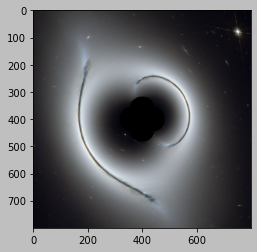

In [7]:
plt.imshow(np.reshape(t1, (image_Mat_Len, image_Mat_Len,3)))

In [4]:
lensedimage = lensed_image(image_data)

Text(0.5, 1.0, 'output')

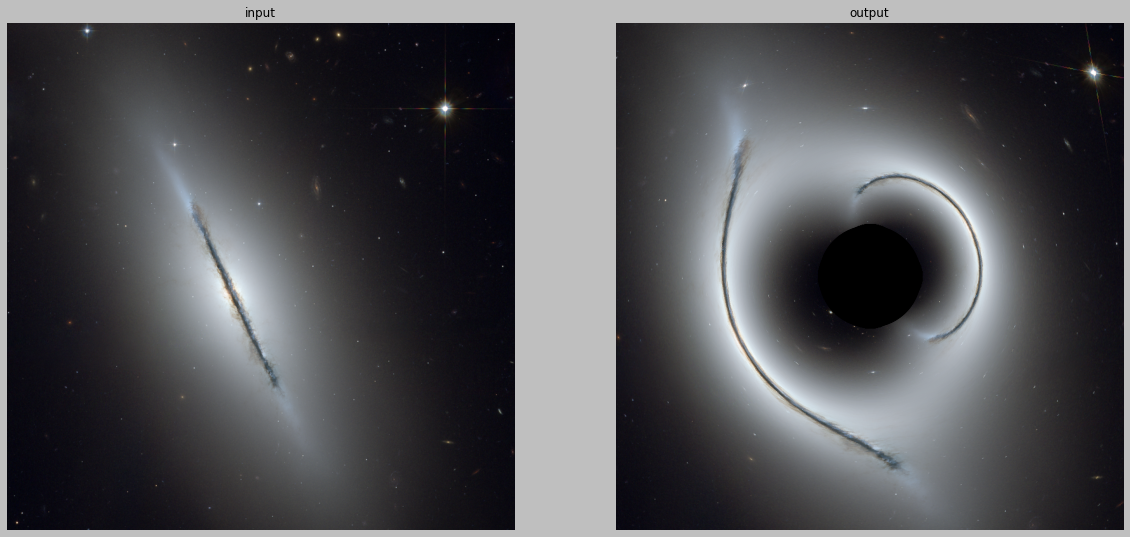

In [6]:
fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,2,1)
plt.imshow(image_data)
plt.axis('off')
plt.title('input')
fig.add_subplot(1,2,2)
plt.imshow(lensedimage)
plt.gca().add_patch(ptch.Circle((image_Mat_Len/2, image_Mat_Len/2),radius=image_Mat_Len/10, color='black'))
plt.axis('off')
plt.title('output')

In [ ]:
[]